## Setup and Import Libraries

In [1]:
import os
from pprint import pprint
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langchain.chat_models import init_chat_model
from langchain_core.messages import AIMessage,HumanMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from dotenv import load_dotenv


In [2]:
load_dotenv()

True

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
llm = init_chat_model(model="openai:o4-mini")

## How to use chat messages as our graph state

### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)

In [5]:
messages=[AIMessage(content=f"Please tell me how can I help", name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding", name="Saad"))
messages.append(AIMessage(content=f"Which programming language you want to learn", name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language", name="Saad"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Saad

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Saad

I want to learn python programming language


## Chat Models

In [6]:
result = llm.invoke(input=messages)
result

AIMessage(content='Here’s a step‐by‐step plan to get you started with Python:\n\n1. Install Python & Pick an Editor  \n   • Download Python (3.x) from python.org and run the installer (check “Add to PATH”).  \n   • Choose an editor/IDE:  \n     – VS Code (free, extensible)  \n     – PyCharm Community Edition  \n     – Jupyter Notebook (great for data‐science experiments)  \n\n2. Learn the Basics  \n   a. Syntax & Data Types  \n     – Variables, numbers (int, float), strings  \n     – Lists, tuples, dictionaries, sets  \n   b. Control Flow  \n     – if/elif/else  \n     – for loops, while loops  \n     – list comprehensions  \n   c. Functions & Modules  \n     – def, return, parameters  \n     – import statements  \n   d. File I/O & Exceptions  \n     – open/read/write files  \n     – try/except blocks  \n\n   Sample “Hello, world!”  \n     ```python\n     def greet(name):\n         return f"Hello, {name}!"\n     print(greet("Saad"))\n     ```\n\n3. Practice with Small Projects  \n   • 

In [7]:
result.response_metadata

{'token_usage': {'completion_tokens': 796,
  'prompt_tokens': 62,
  'total_tokens': 858,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 192,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'o4-mini-2025-04-16',
 'system_fingerprint': None,
 'id': 'chatcmpl-CEuuKBOmTPjRILlzpCEwnf4MFvQNz',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

In [8]:
def add(a:int, b:int)-> int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a + b

## Binding Tool with LLM

In [9]:
llm_with_tools = llm.bind_tools([add])

In [10]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2", name="Saad")])

In [11]:
tool_call.tool_calls

[]

## Using Messages as State

In [12]:
class State(TypedDict):
    messages:list[AnyMessage]

## Reducers

Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [13]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

### Reducers with add_messages

In [14]:
initial_messages = [AIMessage(content=f"Please tell me how can I help", name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding", name="Saad"))

initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Saad')]

In [15]:
ai_message = AIMessage(content=f"Which programming language you want to learn", name="LLMModel")

ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [16]:
add_messages(initial_messages, ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='928c6523-e265-46c8-8ee1-12707bf38ab6'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Saad', id='6fd24bef-3db6-4a3e-9d8b-b9b51964aa90'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='482b7569-8184-45b0-aa95-ab336745e9f7')]

## Chatbot Node Functionality

In [17]:
def llm_tool(state:State):
    return {"messages": [llm_with_tools.invoke(input=state["messages"])]}

## Build Graph

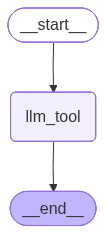

In [18]:
graph_builder = StateGraph(State)

# Add Nodes
graph_builder.add_node(node="llm_tool", action=llm_tool)

# Add Edges
graph_builder.add_edge(start_key=START, end_key="llm_tool")
graph_builder.add_edge(start_key="llm_tool", end_key=END)

# Compile Graph
compiled_graph = graph_builder.compile()

# Display Graph
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

## Invocation

In [19]:
messages = compiled_graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================

2 plus 2 equals 4.


## Adding Tool Node

In [21]:
tools=[add]

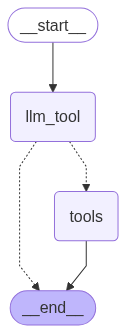

In [22]:
graph_builder = StateGraph(State)

## Add nodes
graph_builder.add_node(node="llm_tool", action=llm_tool)
graph_builder.add_node(node="tools", action=ToolNode(tools))

## Add Edge
graph_builder.add_edge(start_key=START, end_key="llm_tool")
graph_builder.add_conditional_edges(
    source="llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    path=tools_condition
)
graph_builder.add_edge(start_key="tools", end_key=END)

# Compile Graph
compiled_graph = graph_builder.compile()

# Display Graph
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [23]:
messages = compiled_graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (call_SPcW05p99tjExUSOrIwpy5aG)
 Call ID: call_SPcW05p99tjExUSOrIwpy5aG
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [24]:
messages = compiled_graph.invoke({"messages":"What Machine Learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What Machine Learning
================================== Ai Message ==================================

Machine learning (ML) is a subfield of artificial intelligence (AI) focused on building algorithms and statistical models that enable computers to “learn” patterns and make predictions or decisions without being explicitly programmed for every specific task. Instead of following step-by-step instructions written by a programmer, an ML system identifies structure in data and uses it to infer rules or predictions.

Key points:

1. How it works  
   • Data collection: gather historical examples (features and, in supervised cases, labels)  
   • Feature engineering: clean, normalize and transform raw inputs into useful numerical representations  
   • Model training: use an algorithm to adjust internal parameters so the model’s outputs match known answers (supervised) or discover hidden structure (unsupervi